# 안개 발생 진단 분류 모델 생성

## 데이터 설명
- 컬럼

    - `Year` : 년도
    - `Month` : 월
    - `Day` : 일
    - `Time` : 시간 (0 ~ 23)
    - `Minute` : 분 (10분 단위)
    - `STN_ID` : 지점 번호
    - `WS10(deg)` : 10분 평균 풍향, 단위: deg
    - `WS10(m/s)` : 10분 평균 풍속, 단위: m/s
    - `TA` : 1분 평균 기온 10분 주기, 단위: C
    - `RE` : 강수 유무 (0:무강수, 1:강수)
    - `HM` : 1분 평균 상대 습도 10분 주기, 단위: %
    - `sun10` : 1분 일사량 10분단위 합계, 단위: MJ
    - `TS` : 1분 평균 지면온도 10분 주기, 단위: C
    - `VIS1` : 1분 평균 시정 10분 주기, 단위: C (VIS1 변수는 시정 구간을 알 수 있는 변수로 검증 데이터에서는 제외)
    - `class` : 시정 구간

- 시정 계급 기준 (비고: 안개의 기준)

    - `1` : 0 < 시정 < 200
    - `2` : 200 <= 시정 < 500
    - `3` : 500 <= 시정 < 1000
    - `4` : 1000 <= 시정


## 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
os.getcwd()

'/content'

In [4]:
content_dir = os.getcwd()
fog_folder = "drive/MyDrive/weather-contest/fog_data"
os.makedirs(fog_folder, exist_ok=True)

In [5]:
os.name

'posix'

In [6]:
def get_colab_path(train_dataset_name, test_dataset_name):

    fog_folder = "drive/MyDrive/weather_bigdata/fog_data"
    os.makedirs(fog_folder, exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    train_path = os.path.join(os.getcwd(), fog_folder, train_dataset_name)
    test_path = os.path.join(os.getcwd(), fog_folder, test_dataset_name)

    return train_path, test_path

In [7]:
def get_local_path(train_dataset_name, test_dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 상위 디렉토리에 fog_data가 없다면 fog_data 폴더 생성
    # (이미 폴더 있어도 exist_ok=True면 넘어감)
    os.makedirs("fog_data", exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    train_path = os.path.join(os.getcwd(), "fog_data", train_dataset_name)
    test_path = os.path.join(os.getcwd(), "fog_data", test_dataset_name)

    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_path = train_path.replace("\\", "/")
        test_path = test_path.replace("\\", "/")

    # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_path, test_path

In [8]:
train_path, test_path = get_colab_path("fog_train_mod.csv", "fog_test_mod.csv")

In [9]:
!pip -q install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 17.1 MB/s eta 0:00:00


In [10]:
!pip -q install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.6 MB/s eta 0:00:00


In [11]:
!pip install imbalanced-learn

In [12]:
# !pip -q install pycaret[full]

In [13]:
# !pip show scikit-learn

In [14]:
# !pip -q install --upgrade scikit-learn

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import optuna
from optuna.samplers import TPESampler

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB

from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer


import warnings
warnings.filterwarnings(action='ignore')

In [16]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [17]:
train_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,...,ts,vis1,class,is_fog,ws10_dir,season,dew_point,t-td,t-sst,dew_reached
0,I,1,1,0,10,A,0.0,0.0,-6.4,0.0,...,-2.8,20000.0,4,0,N,winter,-17.680941,11.280941,14.880941,0
1,I,1,1,0,20,A,0.0,0.0,-6.3,0.0,...,-2.7,20000.0,4,0,N,winter,-17.886195,11.586195,15.186195,0
2,I,1,1,0,30,A,0.0,0.0,-6.3,0.0,...,-2.6,20000.0,4,0,N,winter,-17.273211,10.973211,14.673211,0


In [18]:
test_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


In [19]:
# 상관관계 높은 컬럼 리스트
high_corr = ["dew_point", "t-td", "t-sst", "ts"]

In [20]:
# 상관관계 높은 컬럼 삭제
train_df = train_df.drop(high_corr, axis=1)

In [21]:
# 월 데이터 담은 컬럼도 삭제
date_cols = ["year", "month", "day", "time", "minute"]
train_df = train_df.drop(date_cols, axis=1)

In [22]:
# 방위, vis1 담은 컬럼도 삭제
train_df = train_df.drop(["ws10_deg", "vis1"], axis=1)

## 모델링

### 데이터 분리

#### Train, Validation 데이터 분리

In [23]:
# Target 컬럼 : class
target = "class"

# train_df의 컬럼들 중 target (class) 제외한 컬럼들 features에 선언
features = train_df.drop(columns=[target]).columns

In [24]:
# validation 데이터셋 생성
# stratify=train_df[target] : validation 데이터의 분류 target 비율을 train 데이터와 같게 맞춰준다
train, val = train_test_split(train_df, train_size=0.75, random_state=42, stratify=train_df[target])

In [25]:
# train, validation 데이터셋 shape 확인
train.shape, val.shape

((2246137, 11), (748713, 11))

In [26]:
train[target].value_counts(normalize=True)

class
4    0.989408
2    0.003998
3    0.003987
1    0.002607
Name: proportion, dtype: float64

In [27]:
val[target].value_counts(normalize=True)

class
4    0.989408
2    0.003999
3    0.003987
1    0.002606
Name: proportion, dtype: float64

### 인코딩

#### Label Encoding

In [28]:
# stn_id를 각각 1 ~ 5로 정한 딕셔너리 생성
stn_id_map = {"A" : 1,
              "B" : 2,
              "C" : 3,
              "D" : 4,
              "E" : 5}

In [29]:
season_map = {"spring" : 1,
              "summer" : 2,
              "autumn" : 3,
              "winter" : 4}

In [30]:
ws10_dir_map = {"N" : 1,
           "NE" : 2,
           "E" : 3,
           "SE" : 4,
           "S" :5,
           "SW" : 6,
           "W" : 7,
           "NW" : 8}

In [31]:
# Label Encoding 적용을 위해 train, val, test 데이터 copy()
train_labeled = train.copy()
val_labeled = val.copy()
test_labeled = test_df.copy()

In [32]:
# stn_id_map을 바탕으로 stn_id 컬럼 mapping
train_labeled["stn_id"] = train_labeled["stn_id"].map(stn_id_map)
val_labeled["stn_id"] = val_labeled["stn_id"].map(stn_id_map)
test_labeled["stn_id"] = test_labeled["stn_id"].map(stn_id_map)

In [33]:
train_labeled

,stn_id,ws10_ms,ta,re,hm,sun10,class,is_fog,ws10_dir,season,dew_reached
1542855,2,1.1,27.5,0.0,79.8,0.00,4,0,SE,summer,0
2801577,4,3.2,6.8,0.0,81.2,0.00,4,0,N,spring,0
1217538,1,1.3,-3.8,0.0,83.3,0.00,4,0,N,winter,0
2730986,4,3.4,12.8,0.0,35.0,0.16,4,0,W,autumn,0
1208,1,3.6,-1.5,0.0,62.8,0.19,4,0,NW,winter,0
...,...,...,...,...,...,...,...,...,...,...,...
2920168,5,1.3,25.1,0.0,83.8,0.05,4,0,SW,summer,0
2260247,1,1.7,17.9,0.0,49.1,0.00,4,0,NW,autumn,0
1459946,2,1.7,21.2,0.0,60.1,0.23,4,0,N,autumn,0
1152528,1,2.1,23.5,0.0,74.7,0.00,4,0,SE,summer,0


In [34]:
# season_map을 바탕으로 stn_id 컬럼 mapping
train_labeled["season"] = train_labeled["season"].map(season_map)
val_labeled["season"] = val_labeled["season"].map(season_map)
# test_labeled["season"] = test_labeled["season"].map(season_map)

In [35]:
# ws10_dir_map을 바탕으로 stn_id 컬럼 mapping
train_labeled["ws10_dir"] = train_labeled["ws10_dir"].map(ws10_dir_map)
val_labeled["ws10_dir"] = val_labeled["ws10_dir"].map(ws10_dir_map)
# test_labeled["ws10_dir"] = test_labeled["ws10_dir"].map(ws10_dir_map)

In [36]:
train_labeled.head(3)

,stn_id,ws10_ms,ta,re,hm,sun10,class,is_fog,ws10_dir,season,dew_reached
1542855,2,1.1,27.5,0.0,79.8,0.0,4,0,4,2,0
2801577,4,3.2,6.8,0.0,81.2,0.0,4,0,1,1,0
1217538,1,1.3,-3.8,0.0,83.3,0.0,4,0,1,4,0


In [37]:
val_labeled.head(3)

,stn_id,ws10_ms,ta,re,hm,sun10,class,is_fog,ws10_dir,season,dew_reached
1551862,2,2.5,20.7,0.0,60.8,0.00,4,0,3,3,0
2971059,5,6.2,29.1,0.0,59.8,0.24,4,0,7,2,0
234559,1,2.6,29.9,0.0,73.9,0.06,4,0,7,2,0


In [38]:
test_labeled.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,L,1,1,0,0,NaN,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,L,1,1,0,10,NaN,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,L,1,1,0,20,NaN,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


#### X, y 데이터 분리

In [39]:
# train, validation, test 데이터 나눠준다
X_train_labeled = train_labeled[features]
y_train_labeled = train_labeled[target]

# validation 데이터 나눠준다
X_val_labeled = val_labeled[features]
y_val_labeled = val_labeled[target]

# test 데이터 나눠준다 (class 제거)
# X_test_labeled = test_labeled[features]

In [40]:
X_train_labeled.shape, y_train_labeled.shape, X_val_labeled.shape, y_val_labeled.shape

((2246137, 10), (2246137,), (748713, 10), (748713,))

### Baseline 모델 생성

In [41]:
# 의사결정나무 모델로 Baseline 모델 생성
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_labeled, y_train_labeled)

DecisionTreeClassifier(random_state=42)

In [42]:
y_val_pred = dt.predict(X_val_labeled)
# accuracy_score(y_val_labeled, y_val_pred)

### CSI 지수 생성

In [43]:
# CSI 지수 함수 생성
def csi_index(y_true, y_pred):

    model_cm = confusion_matrix(y_true, y_pred)

    H = (model_cm[0][0] + model_cm[1][1] + model_cm[2][2])
    F = (model_cm[0][1] + model_cm[0][2] +
            model_cm[1][0] + model_cm[1][2] +
            model_cm[2][0] + model_cm[2][1] +
            model_cm[3][0] + model_cm[3][1] + model_cm[3][2])
    M = (model_cm[0][3] + model_cm[1][3] + model_cm[2][3])

    model_csi = H / (H + F + M)

    return model_csi

csi_scorer = make_scorer(csi_index, greater_is_better=True)

In [44]:
def model_comparison(models, X_train, y_train, X_val, y_val, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # 모델의 Accuracy, Precision, Recall, F1 score 확인
        accuracy = accuracy_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred, average="weighted")
        recall = recall_score(y_val, y_val_pred, average="weighted")
        f1_score_ = f1_score(y_val, y_val_pred, average="weighted")
        csi_index_ = csi_index(y_val, y_val_pred)
        # rootMeanSqLogErr = get_rmsle(y_val, y_val_pred)

        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                               "Accuracy" : np.round(accuracy, 4),
                               "Precision" : np.round(precision, 4),
                               "Recall" : np.round(recall, 4),
                               "F1 Score" : np.round(f1_score_, 4),
                               "CSI Index" : np.round(csi_index_, 4)
                               # "Accuracy" : '{:.2f}'.format(accuracy),
                               # "Precision" : '{:.2f}'.format(precision),
                               # "Recall" : '{:.2f}'.format(recall),
                               # "F1 Score" : '{:.2f}'.format(f1_score_),
                               # "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))
                               })

    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n======== Models {when} Hyper Parameter Tuning ========\n")

    # return models_df.sort_values(by=["RMSLE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)
    return models_df.sort_values(by=["CSI Index", "Accuracy", "F1 Score"],
                                 ascending=[False, True, False]
                                 ).reset_index(drop=True)


In [45]:
# baseline_model = [("Decision Tree", DecisionTreeClassifier(random_state=42))]
# model_comparison(baseline_model, X_train_labeled, y_train_labeled, X_val_labeled, y_val_labeled)

### 하이퍼 파라미터 튜닝 전 모델 생성 (CatBoost, Naive Bayes)

In [46]:
models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(loss_function='MultiClass', verbose=0, task_type="GPU",random_state=42)),
    # ("Naive Bayes", GaussianNB()),
    # ("Random Forest", RandomForestClassifier(random_state=42))
]

In [47]:
model_comparison(models, X_train_labeled, y_train_labeled, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost,0.9959,0.9960,0.9959,0.9960,0.6174
1,Decision Tree,0.9955,0.9956,0.9955,0.9956,0.5797


## 하이퍼 파라미터 튜닝

### CatBoost

In [ ]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

In [ ]:
# https://practicaldatascience.co.uk/machine-learning/how-to-tune-a-catboostclassifier-model-with-optuna
# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html#configurations
# https://catboost.ai/en/docs/concepts/parameter-tuning#methods-for-hyperparameter-search-by-optuna

def objective_cat(trial):
    params = {
        # "loss_function":'MultiClass',
        "iterations": trial.suggest_int("iterations", 100, 1000),
        # "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        # "verbose": False
    }

    model = CatBoostClassifier(**params,
                               loss_function="MultiClass",
                               silent=True,
                               task_type="GPU",
                               random_state=42)

    model.fit(X_train_labeled, y_train_labeled)
    predictions = model.predict(X_val_labeled)
    csi = csi_index(y_val_labeled, predictions)

    return csi

In [ ]:
study_cat = optuna.create_study(study_name="catboost", direction='maximize', pruner="MedianPruner", sampler=sampler)
study_cat.optimize(objective_cat, n_trials=100)

[I 2024-06-06 09:32:59,746] A new study created in memory with name: catboost
[I 2024-06-06 09:33:08,037] Trial 0 finished with value: 0.02546773849327737 and parameters: {'iterations': 207, 'learning_rate': 0.0047340227734041914, 'depth': 10, 'l2_leaf_reg': 1.7061975743910147e-05, 'bootstrap_type': 'Poisson', 'random_strength': 1.8735548907110496e-05, 'bagging_temperature': 0.9717820827209607, 'od_type': 'IncToDec', 'od_wait': 30, 'min_data_in_leaf': 31}. Best is trial 0 with value: 0.02546773849327737.
[I 2024-06-06 09:33:15,661] Trial 1 finished with value: 0.00010068465565847765 and parameters: {'iterations': 356, 'learning_rate': 0.0011851515660043109, 'depth': 7, 'l2_leaf_reg': 0.00106362915273837, 'bootstrap_type': 'Poisson', 'random_strength': 1.49414578394363, 'bagging_temperature': 0.23956189066697242, 'od_type': 'Iter', 'od_wait': 50, 'min_data_in_leaf': 25}. Best is trial 0 with value: 0.02546773849327737.
[I 2024-06-06 09:33:24,851] Trial 2 finished with value: 0.015303562

In [ ]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best CSI Index:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'iterations': 904, 'learning_rate': 0.08791641275815368, 'depth': 10, 'l2_leaf_reg': 0.20316887640148765, 'bootstrap_type': 'Poisson', 'random_strength': 0.0013974245504260433, 'bagging_temperature': 0.783946059928889, 'od_type': 'IncToDec', 'od_wait': 34, 'min_data_in_leaf': 65}
-----------------------------------------------------------------------------------------------------------------
Best CSI Index:
0.14768034976924946


In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [ ]:
cat_optuna = CatBoostClassifier(**study_cat.best_params)

### Naive Bayes

In [ ]:
def objective_gnb(trial):
    params = {
        "var_smoothing" : trial.suggest_float("var_smoothing", 0, 1e-9, log=True)
    }

    model = GaussianNB(**params)

    model.fit(X_train_labeled, y_train_labeled)
    predictions = model.predict(X_val_labeled)
    csi = csi_index(y_val_labeled, predictions)

    return csi

In [ ]:
study_gnb = optuna.create_study(study_name="GaussianNB", direction='maximize', sampler=sampler)
study_gnb.optimize(objective_gnb, n_trials=100)

[I 2024-06-06 10:55:38,985] A new study created in memory with name: GaussianNB
[W 2024-06-06 10:55:38,988] Trial 0 failed with parameters: {} because of the following error: ValueError('The `low` value must be larger than 0 for a log distribution (low=0, high=1e-09).').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-93-1f0d25c080af>", line 3, in objective_gnb
    "var_smoothing" : trial.suggest_float("var_smoothing", 0, 1e-9, log=True)
  File "/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py", line 162, in suggest_float
    distribution = FloatDistribution(low, high, log=log, step=step)
  File "/usr/local/lib/python3.10/dist-packages/optuna/distributions.py", line 148, in __init__
    raise ValueError(
ValueError: The `low` value must be larger than 0 for a log distribution (low=0, high=1e-09).
[W 2024-06-06 10:55:38,989] Trial 

ValueError: The `low` value must be larger than 0 for a log distribution (low=0, high=1e-09).

## 데이터 불균형 문제

### 언더샘플링

#### RandomUnderSampler

In [50]:
# https://wndofla123.tistory.com/30
# https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html#edited-nearest-neighbours

# 불균형 데이터 처리 - 언더 샘플링
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule

# 불균형 데이터 처리 - 오버 샘플링
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE

# 데이터 검증
from sklearn.ensemble import RandomForestClassifier #랜덤 포레스트
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

In [51]:
# count_and_plot 그리기 함수
from collections import Counter
from matplotlib import pyplot

def count_and_plot(y):
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)'%(k,v,v / len(y) * 100))
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()

Class=4, n=2222346 (98.941%)
Class=2, n=8981 (0.400%)
Class=3, n=8955 (0.399%)
Class=1, n=5855 (0.261%)


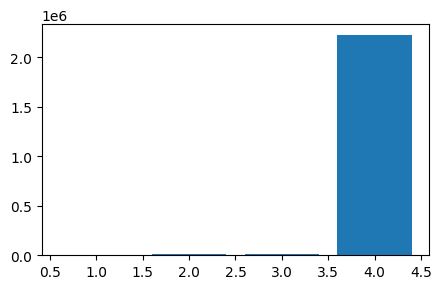

In [ ]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_labeled)

In [ ]:
rus = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_labeled, y_train_labeled)

Class=1, n=5855 (25.000%)
Class=2, n=5855 (25.000%)
Class=3, n=5855 (25.000%)
Class=4, n=5855 (25.000%)


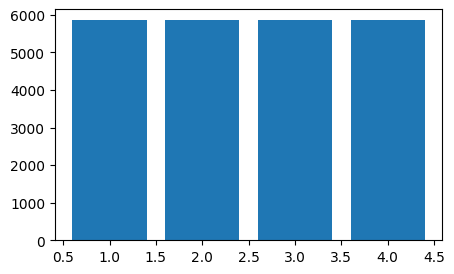

In [ ]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_res)

In [ ]:
# tl = TomekLinks()
# X_train_tl, y_train_tl = tl.fit_resample(X_train_labeled, y_train_labeled)

In [ ]:
# plt.figure(figsize=(5, 3))
# count_and_plot(y_train_tl)

In [ ]:
# # 전체 데이터셋으로 하이퍼파라미터 튜닝했던 데이터 로드
# pkl_path = "/content/drive/MyDrive/weather-contest/fog_data/cat_model_tek.pkl"
# with open(pkl_path, 'rb') as f:
# 	cat_opt = pickle.load(f)

In [ ]:
# ruv_cat = cat_opt.fit(X_res, y_res)

In [ ]:
# y_pred_ruv = ruv_cat.predict(X_val_labeled)

In [ ]:
# csi_index : 0.03681626651277146
# csi_index(y_val_labeled, y_pred_ruv)

##### RandomUnderSampler 통한 Train dataset으로 다시 모델링 (하이퍼파라미터 튜닝 전)

In [ ]:
models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(loss_function='MultiClass', verbose=0, task_type="GPU",random_state=42)),
    ("Naive Bayes", GaussianNB()),
    ("Random Forest", RandomForestClassifier(random_state=42))
]

In [ ]:
model_comparison(models, X_train_res, y_train_res, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Random Forest,0.8504,0.9893,0.8504,0.9116,0.0408
1,CatBoost,0.8370,0.9891,0.8370,0.9037,0.0359
2,Decision Tree,0.7529,0.9887,0.7529,0.8516,0.0220
3,Naive Bayes,0.6464,0.9887,0.6464,0.7791,0.0109


#### TomekLinks

In [52]:
tl = TomekLinks()
X_train_tl, y_train_tl = tl.fit_resample(X_train_labeled, y_train_labeled)

Class=4, n=2222293 (99.089%)
Class=2, n=7072 (0.315%)
Class=3, n=7511 (0.335%)
Class=1, n=5855 (0.261%)


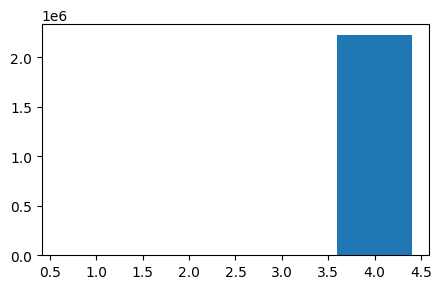

In [53]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_tl)

##### TomekLinks 통한 Train dataset으로 다시 모델링 (하이퍼파라미터 튜닝 전)

In [54]:
model_comparison(models, X_train_tl, y_train_tl, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost,0.9959,0.9959,0.9959,0.9959,0.6121
1,Decision Tree,0.9955,0.9955,0.9955,0.9955,0.5731


#### OSS (OneSidedSelection)

In [55]:
oss = OneSidedSelection(random_state=42)
X_train_oss, y_train_oss = oss.fit_resample(X_train_labeled, y_train_labeled)

Class=1, n=5855 (0.265%)
Class=2, n=7073 (0.320%)
Class=3, n=7496 (0.339%)
Class=4, n=2192696 (99.077%)


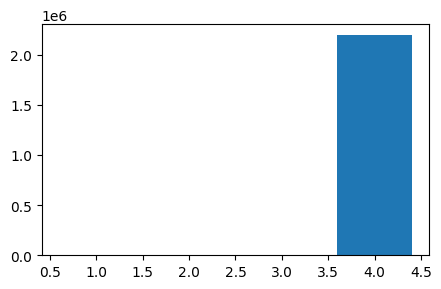

In [56]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_oss)

##### OSS 통한 Train dataset으로 다시 모델링 (하이퍼파라미터 튜닝 전)

In [57]:
model_comparison(models, X_train_oss, y_train_oss, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost,0.9959,0.9959,0.9959,0.9959,0.6105
1,Decision Tree,0.9955,0.9955,0.9955,0.9955,0.5731


#### ENN (Edited Nearest Neighbours)

In [58]:
enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=5)
X_train_enn, y_train_enn = enn.fit_resample(X_train_labeled, y_train_labeled)

Class=1, n=5855 (0.263%)
Class=2, n=552 (0.025%)
Class=3, n=780 (0.035%)
Class=4, n=2220313 (99.677%)


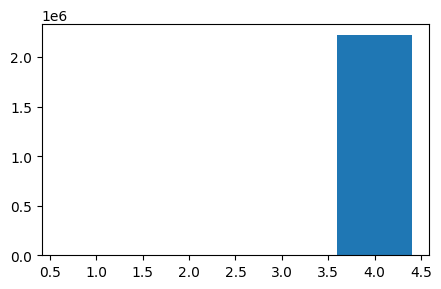

In [59]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_enn)

In [60]:
model_comparison(models, X_train_enn, y_train_enn, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9934,0.9956,0.9934,0.9929,0.3763
1,CatBoost,0.9932,0.9963,0.9932,0.9926,0.3612


#### Neighbourhood Cleaning Rule

In [61]:
ncr = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5)
X_train_ncr, y_train_ncr = ncr.fit_resample(X_train_labeled, y_train_labeled)

In [62]:
model_comparison(models, X_train_ncr, y_train_ncr, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost,0.9952,0.9958,0.9952,0.9952,0.548
1,Decision Tree,0.9951,0.9956,0.9951,0.9951,0.534


### 오버샘플링

#### RandomOverSampler

In [ ]:
# 랜덤오버샘플링
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_labeled, y_train_labeled)

Class=4, n=2222346 (25.000%)
Class=2, n=2222346 (25.000%)
Class=3, n=2222346 (25.000%)
Class=1, n=2222346 (25.000%)


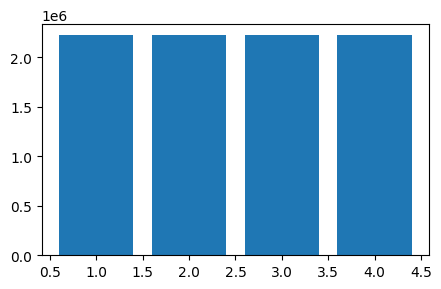

In [ ]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_ros)

In [ ]:
model_comparison(models, X_train_ros, y_train_ros, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9861,0.9863,0.9861,0.9862,0.1753
1,CatBoost,0.8949,0.9891,0.8949,0.9371,0.0558
2,Naive Bayes,0.6468,0.9887,0.6468,0.7793,0.0110


#### SMOTE

In [ ]:
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_labeled, y_train_labeled)

Class=4, n=2222346 (25.000%)
Class=2, n=2222346 (25.000%)
Class=3, n=2222346 (25.000%)
Class=1, n=2222346 (25.000%)


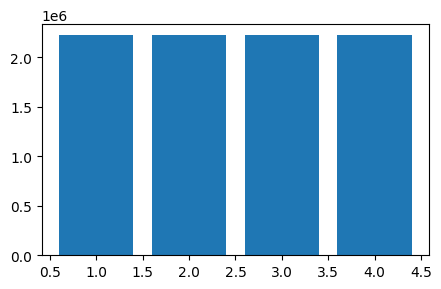

In [ ]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_sm)

In [ ]:
model_comparison(models, X_train_sm, y_train_sm, X_val_labeled, y_val_labeled)

#### Borderline SMOTE

In [66]:
bor_sm = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = bor_sm.fit_resample(X_train_labeled, y_train_labeled)

Class=4, n=2222346 (25.000%)
Class=2, n=2222346 (25.000%)
Class=3, n=2222346 (25.000%)
Class=1, n=2222346 (25.000%)


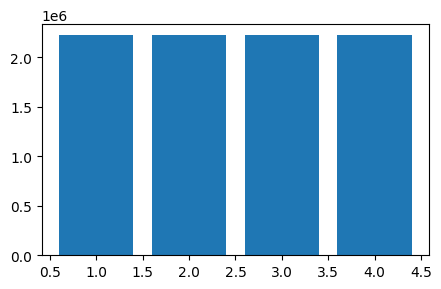

In [67]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_bsm)

In [68]:
model_comparison(models, X_train_bsm, y_train_bsm, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost,0.9956,0.9956,0.9956,0.9956,0.582
1,Decision Tree,0.9955,0.9955,0.9955,0.9955,0.576


#### ADASYN

In [63]:
ada = ADASYN(random_state=42)
X_train_ada, y_train_ada = ada.fit_resample(X_train_labeled, y_train_labeled)

Class=4, n=2222346 (24.992%)
Class=2, n=2223257 (25.003%)
Class=3, n=2223843 (25.009%)
Class=1, n=2222671 (24.996%)


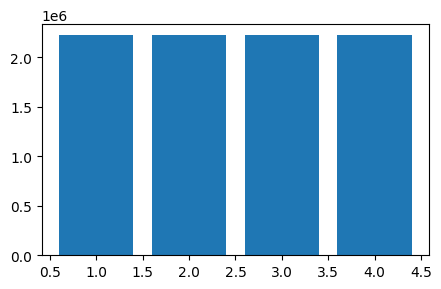

In [64]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_ada)

In [65]:
model_comparison(models, X_train_ada, y_train_ada, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost,0.9957,0.9957,0.9957,0.9957,0.5933
1,Decision Tree,0.9955,0.9955,0.9955,0.9955,0.5715


## 하이퍼 파라미터 튜닝

### 언더샘플링한 데이터로 진행 (RandomUnderSampler)

#### CatBoost

In [ ]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

In [ ]:
# 전체 데이터셋으로 서치했던 하이퍼파라미터 범위 참고
# -> 범위를 참고하여 좁혀서 다시 Optuna를 통해 하이퍼파라미터 튜닝 시도

# {'iterations': 904,
#  'learning_rate': 0.08791641275815368,
#  'depth': 10,
#  'l2_leaf_reg': 0.20316887640148765,
#  'bootstrap_type': 'Poisson',
#  'random_strength': 0.0013974245504260433,
#  'bagging_temperature': 0.783946059928889,
#  'od_type': 'IncToDec',
#  'od_wait': 34,
#  'min_data_in_leaf': 65}

In [ ]:
# https://practicaldatascience.co.uk/machine-learning/how-to-tune-a-catboostclassifier-model-with-optuna
# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html#configurations
# https://catboost.ai/en/docs/concepts/parameter-tuning#methods-for-hyperparameter-search-by-optuna

def objective_res_cat(trial):
    params = {
        # "loss_function":'MultiClass',
        "iterations": trial.suggest_int("iterations", 700, 1000),
        # "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-1, 1.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 1e-1, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.5, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 30, 50),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 100),
        # "verbose": False
    }

    model = CatBoostClassifier(**params,
                               loss_function="MultiClass",
                               silent=True,
                               task_type="GPU",
                               random_state=42)

    model.fit(X_train_res, y_train_res)
    predictions = model.predict(X_val_labeled)
    csi = csi_index(y_val_labeled, predictions)

    return csi

In [ ]:
study_res_cat = optuna.create_study(study_name="catboost_res",
                                    direction='maximize',
                                    pruner="MedianPruner",
                                    sampler=sampler)

study_res_cat.optimize(objective_res_cat, n_trials=100)

[I 2024-06-09 09:42:31,194] A new study created in memory with name: catboost_res
[I 2024-06-09 09:42:40,065] Trial 0 finished with value: 0.031961789982903624 and parameters: {'iterations': 812, 'learning_rate': 0.00892718030435363, 'depth': 8, 'l2_leaf_reg': 0.3968793330444371, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0013066739238053278, 'bagging_temperature': 0.9330880728874675, 'od_type': 'Iter', 'od_wait': 30, 'min_data_in_leaf': 99}. Best is trial 0 with value: 0.031961789982903624.
[I 2024-06-09 09:42:43,944] Trial 1 finished with value: 0.024714263458297334 and parameters: {'iterations': 950, 'learning_rate': 0.0016305687346221474, 'depth': 4, 'l2_leaf_reg': 0.1525472945805261, 'bootstrap_type': 'Poisson', 'random_strength': 0.007309539835912915, 'bagging_temperature': 0.645614570099021, 'od_type': 'IncToDec', 'od_wait': 36, 'min_data_in_leaf': 68}. Best is trial 0 with value: 0.031961789982903624.
[I 2024-06-09 09:42:47,291] Trial 2 finished with value: 0.0265732637

In [ ]:
print("Best hyperparameters:", study_res_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best CSI Index:", study_res_cat.best_value, sep="\n")

Best hyperparameters:
{'iterations': 923, 'learning_rate': 0.00979258152234309, 'depth': 10, 'l2_leaf_reg': 0.2353487947977851, 'bootstrap_type': 'Bayesian', 'random_strength': 0.006712500647052562, 'bagging_temperature': 0.567278569703178, 'od_type': 'IncToDec', 'od_wait': 38, 'min_data_in_leaf': 59}
-----------------------------------------------------------------------------------------------------------------
Best CSI Index:
0.03457977711761839


In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_res_cat)

In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_res_cat)

In [ ]:
cat_res_optuna = CatBoostClassifier(**study_res_cat.best_params)

In [ ]:
# 언더샘플링 후 하이퍼파라미터 튜닝 거친 모델 pickle 저장
with open(file='/content/drive/MyDrive/weather-contest/fog_data/cat_res_model_tek.pkl', mode='wb') as f:
    pickle.dump(study_res_cat, f)

## 모델링 (CatBoost)
- 임시로 임의의 하이퍼파라미터 사용

In [72]:
best_params = {'iterations': 923,
               'learning_rate': 0.00979258152234309,
               'depth': 10,
               'l2_leaf_reg': 0.2353487947977851,
               'bootstrap_type': 'Bayesian',
               'random_strength': 0.006712500647052562,
               'bagging_temperature': 0.567278569703178,
               'od_type': 'IncToDec',
               'od_wait': 38,
               'min_data_in_leaf': 59,
               }

In [77]:
cat = CatBoostClassifier(loss_function='MultiClass', verbose=0, task_type="GPU",random_state=42,
                         iterations= 923,
                         learning_rate= 0.00979258152234309,
                         depth= 10,
                         l2_leaf_reg= 0.2353487947977851,
                         bootstrap_type= "Bayesian",
                         random_strength= 0.006712500647052562,
                         bagging_temperature= 0.567278569703178,
                         od_type= "IncToDec",
                         od_wait= 38,
                         min_data_in_leaf= 59)

In [78]:
cat_model = [("CatBoost", cat)]

In [79]:
model_comparison(cat_model, X_train_labeled, y_train_labeled, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost,0.9958,0.9959,0.9958,0.9958,0.6047


In [81]:
cat_model_default =[
    ("CatBoost", CatBoostClassifier(loss_function='MultiClass', verbose=0, task_type="GPU",random_state=42))
]

In [82]:
model_comparison(cat_model_default, X_train_labeled, y_train_labeled, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost,0.9959,0.996,0.9959,0.996,0.6174


In [83]:
cat_default = CatBoostClassifier(loss_function='MultiClass', verbose=0, task_type="GPU",random_state=42)

In [84]:
cat_default.fit(X_train_labeled, y_train_labeled)

In [85]:
train_path

'/content/drive/MyDrive/weather_bigdata/fog_data/fog_train_mod.csv'

In [87]:
# cat_default 모델 pickle 저장
with open(file='/content/drive/MyDrive/weather_bigdata/fog_data/cat_model_default.pkl', mode='wb') as f:
    pickle.dump(cat_default, f)